In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
import cv2
import os
from typing import Union
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from collections import defaultdict, namedtuple
from sklearn.preprocessing import MultiLabelBinarizer
import random
import pandas as pd
import numpy as np

In [3]:
import torch
import torchvision
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset

In [10]:
PATH = Path('../VOCdevkit/VOC2007/')
JSON_PATH = Path('../json')

In [5]:
img_size = 300
batch_size = 64

In [6]:
torch.cuda.set_device(2)

In [7]:
torch.cuda.current_device()

2

# EDA

In [11]:
list(PATH.iterdir())

[PosixPath('../VOCdevkit/VOC2007/Annotations'),
 PosixPath('../VOCdevkit/VOC2007/model-bb1-s1.pth'),
 PosixPath('../VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('../VOCdevkit/VOC2007/model_tmp.pth'),
 PosixPath('../VOCdevkit/VOC2007/model-bb1-s2.pth'),
 PosixPath('../VOCdevkit/VOC2007/model-cls-s1.pth'),
 PosixPath('../VOCdevkit/VOC2007/model-cls-s2.pth'),
 PosixPath('../VOCdevkit/VOC2007/ImageSets'),
 PosixPath('../VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('../VOCdevkit/VOC2007/tmp'),
 PosixPath('../VOCdevkit/VOC2007/mode_tmp.pth'),
 PosixPath('../VOCdevkit/VOC2007/.ipynb_checkpoints'),
 PosixPath('../VOCdevkit/VOC2007/SegmentationObject')]

In [12]:
list(JSON_PATH.iterdir())

[PosixPath('../json/pascal_val2007.json'),
 PosixPath('../json/pascal_test2007.json'),
 PosixPath('../json/pascal_val2012.json'),
 PosixPath('../json/pascal_train2007.json'),
 PosixPath('../json/pascal_train2012.json')]

## Metadata

In [13]:
annotations = json.load(open(JSON_PATH/'pascal_train2007.json'))

In [14]:
annotations.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [15]:
annotations['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [16]:
annotations['annotations'][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [17]:
annotations['categories'][0]

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [18]:
categories = {d['id']:d['name'] for d in annotations['categories']}
categories

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

## Images

In [19]:
IMG_PATH = PATH/'JPEGImages'
list(IMG_PATH.iterdir())[:5]

[PosixPath('../VOCdevkit/VOC2007/JPEGImages/007622.jpg'),
 PosixPath('../VOCdevkit/VOC2007/JPEGImages/000450.jpg'),
 PosixPath('../VOCdevkit/VOC2007/JPEGImages/002505.jpg'),
 PosixPath('../VOCdevkit/VOC2007/JPEGImages/003271.jpg'),
 PosixPath('../VOCdevkit/VOC2007/JPEGImages/006858.jpg')]

In [20]:
annotations['images'][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [21]:
def bounding_box(bb):
    """switch x/y coords to be consistent with numpy, convert height/width into top-left/bottom-right"""
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# make dictionary {img_id:[(cat_id, bbox), (cat_id, bbox), ...]}
def make_anno_dict(anno_json):
    anno_dict = defaultdict(list)
    for anno in anno_json['annotations']:
        if not anno['ignore']:
    #         bb = bounding_box(anno['bbox'])
            bb = np.array(anno['bbox'])  # matplotlib accepts VOC format bounding box, so no need to convert
            anno_dict[anno['image_id']].append(
                (anno['category_id'], bb))
    return anno_dict

# open image
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

def show_by_index(idx:int, annotations:dict):
    img_path = str(IMG_PATH/f'{idx:06d}.jpg')
    img = load_image(img_path)
    
    if idx in annotations.keys():
        print(img_path)
        ax = show_img(img, figsize=(12, 12))
        for item in annotations[idx]:
            b = item[1]
            print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
            draw_rect(ax, b)
            draw_text(ax, b[:2], categories[item[0]])

In [22]:
train_anno = make_anno_dict(annotations)

../VOCdevkit/VOC2007/JPEGImages/000198.jpg
Bounding box:
Y: 133
X: 159
Height: 106
Width: 127


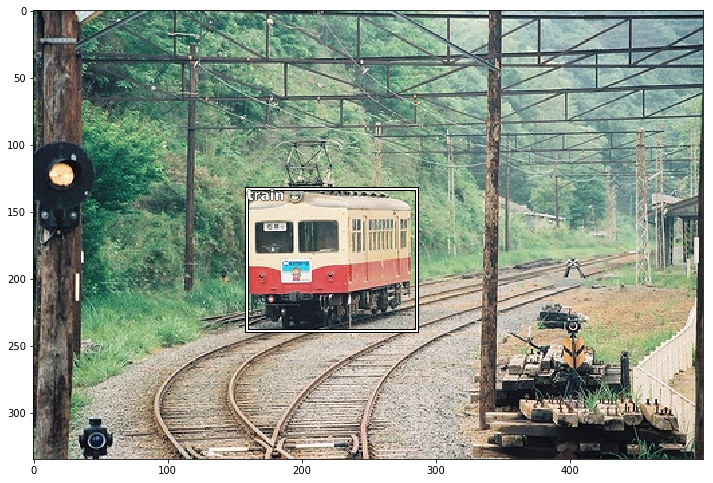

In [23]:
img_ids = list(train_anno.keys())
idx = random.sample(img_ids, 1)[0]
show_by_index(idx, train_anno)

# Single Object Detection

Start from classifying the largest bounding box in an image

## Select the largest bounding box

In [24]:
def get_largest_box(b):
    try:
        max_box = sorted(b, key=lambda x: abs(np.product(x[1][-2:])), reverse=True)
        return max_box[0]
    except:
        raise Exception()

In [25]:
max_train_anno = {k:[get_largest_box(v)] for k,v in train_anno.items()}

VOCdevkit/VOC2007/JPEGImages/009466.jpg
Bounding box:
Y: 219
X: 156
Height: 217
Width: 242


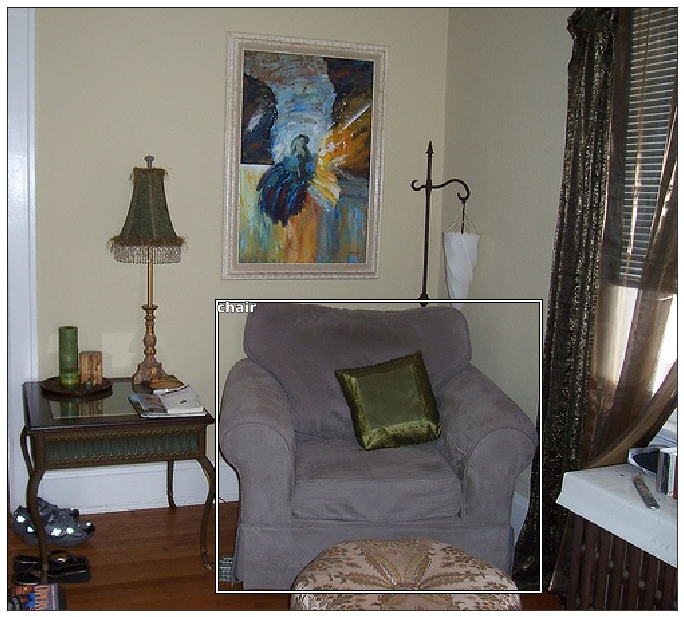

In [21]:
train_ids_max = list(max_train_anno.keys())
idx = random.sample(train_ids_max, 1)[0]
show_by_index(idx, max_train_anno)

## Create labels for multi-class classification

In [26]:
train_labels = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_anno.keys()],
                'label': [categories[max_train_anno[idx][0][0]] for idx in train_anno.keys()]}

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded = le.fit_transform(sorted(set(train_labels['label'])))
label_encoding = dict(zip(sorted(set(train_labels['label'])), label_encoded))
label_encoding

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'diningtable': 10,
 'dog': 11,
 'horse': 12,
 'motorbike': 13,
 'person': 14,
 'pottedplant': 15,
 'sheep': 16,
 'sofa': 17,
 'train': 18,
 'tvmonitor': 19}

### Training set

In [24]:
train_labels_df = pd.DataFrame.from_dict(train_labels, orient='columns')

In [26]:
train_labels_df['label'] = train_labels_df['label'].apply(lambda x: label_encoding[x])

In [27]:
train_labels_df.head(5)

fn  label
0  VOCdevkit/VOC2007/JPEGImages/000012.jpg      6
1  VOCdevkit/VOC2007/JPEGImages/000017.jpg     12
2  VOCdevkit/VOC2007/JPEGImages/000023.jpg     14
3  VOCdevkit/VOC2007/JPEGImages/000026.jpg      6
4  VOCdevkit/VOC2007/JPEGImages/000032.jpg      0

In [28]:
train_labels_df['label'].value_counts()

14    594
6     292
2     167
7     139
11    137
18    124
12    118
0     112
13     95
8      89
17     87
5      86
10     76
3      75
15     61
9      59
1      58
19     54
16     42
4      36
Name: label, dtype: int64

In [ ]:
(PATH/'tmp').mkdir(exist_ok=True)

In [ ]:
train_labels_df.to_csv(PATH/'tmp/train_label.csv', sep=',', index=False, header=True)

### Validation set

In [28]:
vals = json.load(open(JSON_PATH/'pascal_val2007.json'))

In [29]:
val_anno = make_anno_dict(vals)

In [50]:
max_val_anno = {k:[get_largest_box(v)] for k,v in val_anno.items()}

In [51]:
val_ids_max = list(max_val_anno.keys())
val_labels = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_ids_max],
              'label': [categories[max_val_anno[idx][0][0]] for idx in val_ids_max]}

In [52]:
val_labels_df = pd.DataFrame.from_dict(val_labels, orient='columns')
val_labels_df['label'] = val_labels_df['label'].apply(lambda x: label_encoding[x])
val_labels_df.head(5)

fn  label
0  VOCdevkit/VOC2007/JPEGImages/000005.jpg      8
1  VOCdevkit/VOC2007/JPEGImages/000007.jpg      6
2  VOCdevkit/VOC2007/JPEGImages/000009.jpg     12
3  VOCdevkit/VOC2007/JPEGImages/000016.jpg      1
4  VOCdevkit/VOC2007/JPEGImages/000019.jpg      7

In [ ]:
val_labels_df.to_csv(PATH/'tmp/val_label.csv', sep=',', index=False, header=True)

## Creating labels for single bounding box

In [53]:
train_bbox = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_ids_max],
              'label': [categories[max_train_anno[idx][0][0]] for idx in train_ids_max],
              'bbox': [max_train_anno[idx][0][1] for idx in train_ids_max]}

In [54]:
val_bbox = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_ids_max],
            'label': [categories[max_val_anno[idx][0][0]] for idx in val_ids_max],
            'bbox': [max_val_anno[idx][0][1] for idx in val_ids_max]}

In [55]:
train_bbox_df = pd.DataFrame.from_dict(train_bbox, orient='columns')
train_bbox_df['bbox'] = train_bbox_df['bbox'].apply(lambda x: ' '.join(str(p) for p in x))
train_bbox_df['label'] = train_bbox_df['label'].apply(lambda x: label_encoding[x])
train_bbox_df.head(5)

fn  label            bbox
0  VOCdevkit/VOC2007/JPEGImages/000012.jpg      6  155 96 196 174
1  VOCdevkit/VOC2007/JPEGImages/000017.jpg     12   89 77 314 259
2  VOCdevkit/VOC2007/JPEGImages/000023.jpg     14     2 1 241 461
3  VOCdevkit/VOC2007/JPEGImages/000026.jpg      6   89 124 248 88
4  VOCdevkit/VOC2007/JPEGImages/000032.jpg      0  103 77 272 106

In [56]:
val_bbox_df = pd.DataFrame.from_dict(val_bbox, orient='columns')
val_bbox_df['bbox'] = val_bbox_df['bbox'].apply(lambda x: ' '.join(str(p) for p in x))
val_bbox_df['label'] = val_bbox_df['label'].apply(lambda x: label_encoding[x])
val_bbox_df.head(5)

fn  label            bbox
0  VOCdevkit/VOC2007/JPEGImages/000005.jpg      8  164 263 89 109
1  VOCdevkit/VOC2007/JPEGImages/000007.jpg      6  140 49 360 281
2  VOCdevkit/VOC2007/JPEGImages/000009.jpg     12  68 171 202 159
3  VOCdevkit/VOC2007/JPEGImages/000016.jpg      1   91 71 214 402
4  VOCdevkit/VOC2007/JPEGImages/000019.jpg      7  230 87 253 169

In [ ]:
train_bbox_df.to_csv(PATH/'tmp/train_bbox.csv', sep=',', index=False, header=True)

In [ ]:
val_bbox_df.to_csv(PATH/'tmp/val_bbox.csv', sep=',', index=False, header=True)

## Creating labels for multi-label classification

In [91]:
train_labels_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_anno.keys()],
                      'label': [list(zip(*train_anno[idx]))[0] for idx in train_anno.keys()]}

In [92]:
val_labels_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_anno.keys()],
                    'label': [list(zip(*val_anno[idx]))[0] for idx in val_anno.keys()]}

In [115]:
train_labels_multi_df = pd.DataFrame.from_dict(train_labels_multi, orient='columns')
train_labels_multi_df['label'] = train_labels_multi_df['label'].apply(lambda x: set(x))\
                                                               .apply(lambda x: ' '.join([str(n) for n in x]))
train_labels_multi_df.head(5)

fn  label
0  VOCdevkit/VOC2007/JPEGImages/000012.jpg      7
1  VOCdevkit/VOC2007/JPEGImages/000017.jpg  13 15
2  VOCdevkit/VOC2007/JPEGImages/000023.jpg   2 15
3  VOCdevkit/VOC2007/JPEGImages/000026.jpg      7
4  VOCdevkit/VOC2007/JPEGImages/000032.jpg   1 15

In [116]:
val_labels_multi_df = pd.DataFrame.from_dict(val_labels_multi, orient='columns')
val_labels_multi_df['label'] = val_labels_multi_df['label'].apply(lambda x: set(x))\
                                                           .apply(lambda x: ' '.join([str(n) for n in x]))
val_labels_multi_df.head(5)

fn  label
0  VOCdevkit/VOC2007/JPEGImages/000005.jpg      9
1  VOCdevkit/VOC2007/JPEGImages/000007.jpg      7
2  VOCdevkit/VOC2007/JPEGImages/000009.jpg  13 15
3  VOCdevkit/VOC2007/JPEGImages/000016.jpg      2
4  VOCdevkit/VOC2007/JPEGImages/000019.jpg      8

In [118]:
train_labels_multi_df.to_csv(PATH/'tmp/train_labels_multi.csv', sep=',', index=False, header=True)

In [119]:
val_labels_multi_df.to_csv(PATH/'tmp/val_labels_multi.csv', sep=',', index=False, header=True)

## Creating labels for multi-bounding-boxed detection

In [27]:
train_bbox_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in train_anno.keys()],
                    'label': [list(zip(*train_anno[idx]))[0] for idx in train_anno.keys()],
                    'bbox': [np.hstack([*list(zip(*train_anno[idx]))[1]]) for idx in train_anno.keys()]}

In [28]:
val_bbox_multi = {'fn': [IMG_PATH/f'{idx:06d}.jpg' for idx in val_anno.keys()],
                  'label': [list(zip(*val_anno[idx]))[0] for idx in val_anno.keys()],
                  'bbox': [np.hstack([*list(zip(*val_anno[idx]))[1]]) for idx in val_anno.keys()]}

In [30]:
train_bbox_multi_df = pd.DataFrame.from_dict(train_bbox_multi, orient='columns')
train_bbox_multi_df['label'] = train_bbox_multi_df['label'].apply(lambda x: ' '.join([str(n) for n in x]))
train_bbox_multi_df['bbox'] = train_bbox_multi_df['bbox'].apply(lambda x: ' '.join([str(n) for n in x]))
train_bbox_multi_df.head(5)

fn         label  \
0  VOCdevkit/VOC2007/JPEGImages/000012.jpg             7   
1  VOCdevkit/VOC2007/JPEGImages/000017.jpg         15 13   
2  VOCdevkit/VOC2007/JPEGImages/000023.jpg  2 2 15 15 15   
3  VOCdevkit/VOC2007/JPEGImages/000026.jpg             7   
4  VOCdevkit/VOC2007/JPEGImages/000032.jpg     1 1 15 15   

                                                bbox  
0                                     155 96 196 174  
1                        184 61 95 138 89 77 314 259  
2  8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...  
3                                      89 124 248 88  
4  103 77 272 106 132 87 65 36 194 179 19 50 25 1...

In [31]:
val_bbox_multi_df = pd.DataFrame.from_dict(val_bbox_multi, orient='columns')
val_bbox_multi_df['label'] = val_bbox_multi_df['label'].apply(lambda x: ' '.join([str(n) for n in x]))
val_bbox_multi_df['bbox'] = val_bbox_multi_df['bbox'].apply(lambda x: ' '.join([str(n) for n in x]))
val_bbox_multi_df.head(5)

fn        label  \
0  VOCdevkit/VOC2007/JPEGImages/000005.jpg        9 9 9   
1  VOCdevkit/VOC2007/JPEGImages/000007.jpg            7   
2  VOCdevkit/VOC2007/JPEGImages/000009.jpg  13 15 15 15   
3  VOCdevkit/VOC2007/JPEGImages/000016.jpg            2   
4  VOCdevkit/VOC2007/JPEGImages/000019.jpg          8 8   

                                                bbox  
0       262 210 62 129 164 263 89 109 240 193 55 106  
1                                     140 49 360 281  
2  68 171 202 159 149 140 80 144 284 200 43 131 2...  
3                                      91 71 214 402  
4                      230 87 253 169 10 112 256 147

In [32]:
train_bbox_multi_df.to_csv(PATH/'tmp/train_bbox_multi.csv', sep=',', index=False, header=True)

In [33]:
val_bbox_multi_df.to_csv(PATH/'tmp/val_bbox_multi.csv', sep=',', index=False, header=True)

# Image Augmentation

In [30]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

def denormalize(im):
    """Denormalizes images."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im * imagenet_stats[1]) + imagenet_stats[0]

## For images

In [31]:
import math
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, bbox=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if bbox:
        return cv2.warpAffine(im, M, (c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## For bounding boxes  

width-height format => bounding-box format => pixel format => resized pixel format => bounding-box format => width-height format

In [32]:
def make_bb_px(y, x):
    """Makes an image of size x retangular bounding box"""
    r, c, *_ = x.shape
    Y = np.zeros((r, c))
#     print(y)
    y = hw_bb(y).astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y


def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def hw_bb(bb): 
    """Transform from width-height format to bounding box format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])


def bb_hw(bb): 
    """Transform from bounding box format to width-height format.
    
    width-height: [X, Y, width, height]
    bounding-box: [Y, X, left-bottom, right-top]
    """
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

### test bounding box resize

In [220]:
def tsfm(x, bbox, size=300):
    random_degree = (np.random.random()-.50)*20
    Y = make_bb_px(bbox, x)

    # resize
    x = cv2.resize(x, (size, size))
    y = cv2.resize(Y, (size, size))
    # then rotate
    x = rotate_cv(x, random_degree)
    y = rotate_cv(y, random_degree, bbox=True)
    # then random flip
    if np.random.random() > 0.5: 
        x = np.fliplr(x).copy()
        y = np.fliplr(y).copy()

    return x, bb_hw(to_bb(y))

In [221]:
data_bb = train_bbox_df.iloc[20, :]
X_bb = load_image(data_bb[0])
y_bb = np.array([int(c) for c in data_bb[2].split()])
X, Y = tsfm(X_bb, y_bb)

In [222]:
X_bb_tsfm = cv2.resize(X_bb, (img_size, img_size))
y_bb_tsfm = to_bb(cv2.resize(Y, (img_size, img_size)))

In [223]:
X = [X_bb, X]
Y = [y_bb, Y]

Bounding box:
Y: 50
X: 21
Height: 241
Width: 296
Bounding box:
Y: 39.0
X: 109.0
Height: 195.0
Width: 180.0


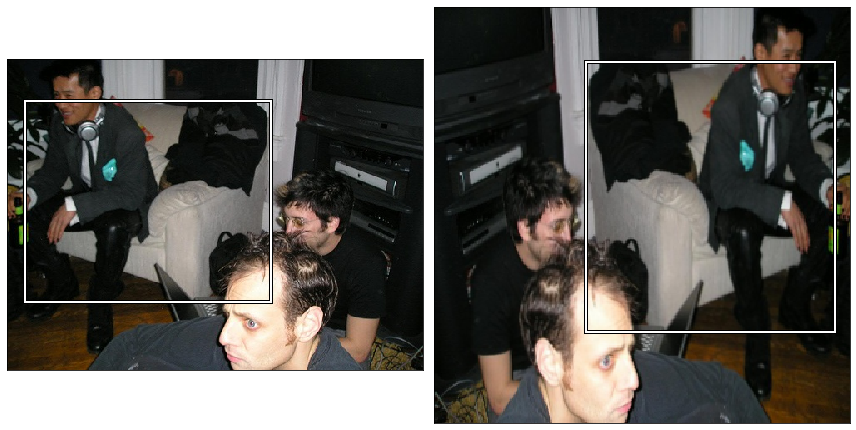

In [224]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img = X[i]
    b = Y[i]
    ax = show_img(img, ax=ax)
    print(f'Bounding box:\nY: {b[1]}\nX: {b[0]}\nHeight: {b[3]}\nWidth: {b[2]}')
    draw_rect(ax, b)
plt.tight_layout()

# Modelling

## Label only (multi-class classification)

### Load Data

In [30]:
class singleObjDataset(Dataset):
    def __init__(self, dataset, fpath_list, transforms=False, sz=img_size):
        self.dataset = dataset
        self.path = fpath_list
        self.sz = img_size
        self.transforms = transforms
        self.y = dataset.iloc[:, 1].values
        self.label2id = {v:k for k,v in categories.items()}
        self.id2label = list(categories.values())
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        path = self.path[i]
        X = load_image(str(path))
        X = cv2.resize(X, (self.sz, self.sz))
        if self.transforms:
            random_degree = (np.random.random()-.50)*20
            X = rotate_cv(X, random_degree)
            if np.random.random() > 0.5: 
                X = np.fliplr(X).copy()
            X = random_crop(X, self.sz, self.sz)
        X = normalize(X)
        X = X.transpose(2, 0, 1)
        y = self.y[i]
        return X, y

In [31]:
train_labels_df = pd.read_csv(PATH/'tmp/train_label.csv')
val_labels_df = pd.read_csv(PATH/'tmp/val_label.csv')

In [32]:
voc_so_train = singleObjDataset(train_labels_df, train_labels_df['fn'].values, transforms=True)
voc_so_valid = singleObjDataset(val_labels_df, val_labels_df['fn'].values)

In [33]:
train_dl = DataLoader(voc_so_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(voc_so_valid, batch_size=batch_size)

In [34]:
X, y = next(iter(train_dl))

In [35]:
y

tensor([ 0, 12, 18, 14, 18,  6,  8,  0, 19, 12, 12, 14,  4,  2, 10, 13,  6, 12,
         0,  6,  6, 14, 15,  6,  6,  7,  0, 15,  8, 14,  6, 12, 17,  5,  6,  0,
         2, 14,  6, 11, 14, 14, 11, 14,  1, 13,  5,  2,  6,  6, 10, 18,  5, 12,
         2,  6,  7, 12, 18,  5, 13, 14, 16, 18])

In [36]:
X.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

### Model

In [61]:
class clsNet(nn.Module):
    def __init__(self, num_classes=20):
        super(clsNet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:-2]
        self.top_model = nn.Sequential(*layers).cuda()
        self.out = 512
        self.bn1 = nn.BatchNorm1d(self.out)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(self.out, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x # we use F.cross_entropy below, it's doing softmax for us

### Learning rate finder

In [33]:
def get_optimizer(model, lr=1e-2, mom=0.9):
    optim = torch.optim.SGD([
        {'params': model.top_model[0:4].parameters(), 'lr': lr/10, 'momentum': mom},
        {'params': model.top_model[4:8].parameters(), 'lr ':lr/3, 'momentum': mom},
        {'params': model.bn1.parameters()},
        {'params': model.bn2.parameters()},
        {'params': model.fc1.parameters()},
        {'params': model.fc2.parameters()}
    ], lr=lr, momentum=mom)
    return optim

In [34]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p):
    checkpoint = torch.load(p)
    m.load_state_dict(checkpoint)
    del checkpoint
    torch.cuda.empty_cache()

In [35]:
def even_mults(start: float, stop: float, n: int)->np.ndarray:
    """Build log-stepped array from `start` to `stop` in `n` steps evenly."""
    mult = stop/start
    step = mult**(1/(n-1))
    return np.array([start*(step**i) for i in range(n)])


def lr_range(lr: Union[float, slice], n)->np.ndarray:
    """Build differential learning rates from `lr`."""
    if not isinstance(lr, slice):
        return lr
    if lr.start:
        lrs = even_mults(lr.start, lr.stop, n)
    else:
        lrs = [lr.stop/10] * (n-1) + [lr.stop]
    return np.array(lrs)

In [36]:
def LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    lrs = lr_range(slice(lr_low, lr_high), iterations)
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
#             scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=1, eta_min=lr_low, last_epoch=-1)
#             scheduler.step()
#             print(scheduler.get_lr())
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind += 1
    load_model(model, str(p))
    torch.cuda.empty_cache()
    return lrs, losses

In [68]:
model = clsNet().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-6, lr_high=1)

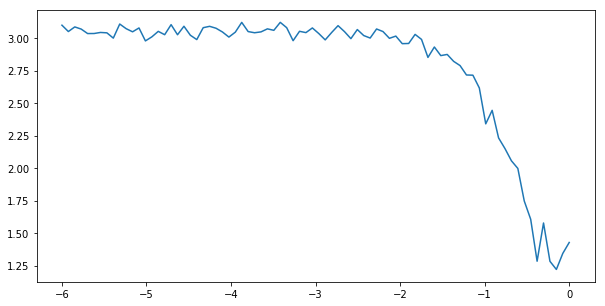

In [69]:
plt.figure(figsize=(10, 5))
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()

### Triangular learning rate training

In [42]:
# def get_triangular_lr(lr_low, lr_high, stepesize):
#     iterations = 2*stepesize
#     iter1 = int(0.35*iterations)
#     iter2 = int(0.85*iter1)
#     iter3 = iterations - iter1 - iter2
#     delta1 = (lr_high - lr_low)/iter1
#     delta2 = (lr_high - lr_low)/(iter1 -1)
#     lrs1 = [lr_low + i*delta1 for i in range(iter1)]
#     lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
#     delta2 = (lrs2[-1] - lr_low)/(iter3)
#     lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
#     return lrs1+lrs2+lrs3

In [37]:
def get_triangular_mom(mom_low=0.85, mom_high=0.95, iterations=50):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    delta_1 = (mom_high - mom_low) / iter1
    delta_2 = (mom_high - mom_low) / (iter2 - 1)
    moms1 = [mom_high - i * delta_1 for i in range(iter1)]
    moms2 = [mom_low + i * delta_2 for i in range(0, iter2)]
    moms3 = [moms2[-1] for i in range(1, iter3 + 1)]

    return moms1 + moms2 + moms3

In [38]:
def get_triangular_lr(lr_optimal, div_factor, iterations):
    iter1 = int(0.45 * iterations)
    iter2 = int(1.0 * iter1)
    iter3 = iterations - iter1 - iter2

    lr_low = lr_optimal/div_factor
    lr_high = lr_optimal

    delta_1 = (lr_high - lr_low) / iter1
    delta_2 = (lr_high - lr_low) / (iter2 - 1)
    lrs1 = [lr_low + i * delta_1 for i in range(iter1)]
    lrs2 = [lr_high - i * delta_2 for i in range(0, iter2)]
    delta_3 = (lrs2[-1] - lr_low / 100) / iter3
    lrs3 = [lrs2[-1] - i * delta_3 for i in range(1, iter3 + 1)]

    return lrs1 + lrs2 + lrs3

In [39]:
def one_cycle_CE(model, train_dl, valid_dl, lr_optimal=1e-4, div_factor=25, epochs=4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr(lr_optimal, div_factor, iterations)
    moms = get_triangular_mom(0.85, 0.95, iterations)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[idx], mom=moms[idx])
#             scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=1, 
#                                                                    eta_min=lr_optimal/div_factor, last_epoch=-1)
#             scheduler.step()
#             print(scheduler.get_lr())
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
            torch.cuda.empty_cache()
        train_losses.append(sum_loss/total)
        print("train loss %.3f" % (sum_loss/total))
        val_loss, val_acc = val_metrics(model, valid_dl)
        val_losses.append(val_loss)
    return train_losses, val_losses

In [40]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        torch.cuda.empty_cache()
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

In [41]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=2, lr_optimal=1e-4):
    for i in range(steps):
        start = datetime.now() 
        loss = one_cycle_CE(model, train_dl, valid_dl, lr_optimal)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [75]:
model = clsNet().cuda()

In [76]:
training_loop(model, train_dl, val_dl, steps=3, lr_optimal=9e-2)

train loss 2.655
val loss 2.014 and accuracy 0.550
train loss 1.469
val loss 1.145 and accuracy 0.679
train loss 1.029
val loss 0.964 and accuracy 0.718
train loss 0.908
val loss 0.950 and accuracy 0.728
----End of step Time elapsed 0:02:30.457273
train loss 0.863
val loss 0.929 and accuracy 0.722
train loss 0.798
val loss 0.883 and accuracy 0.730
train loss 0.735
val loss 0.850 and accuracy 0.740
train loss 0.709
val loss 0.853 and accuracy 0.745
----End of step Time elapsed 0:02:30.810321
train loss 0.676
val loss 0.865 and accuracy 0.739
train loss 0.672
val loss 0.846 and accuracy 0.740
train loss 0.650
val loss 0.825 and accuracy 0.748
train loss 0.594
val loss 0.829 and accuracy 0.747
----End of step Time elapsed 0:02:31.142911


In [80]:
training_loop(model, train_dl, val_dl, steps=2, lr_optimal=9e-2)

train loss 0.600
val loss 0.846 and accuracy 0.740
train loss 0.610
val loss 0.877 and accuracy 0.741
train loss 0.577
val loss 0.835 and accuracy 0.743
train loss 0.546
val loss 0.824 and accuracy 0.747
----End of step Time elapsed 0:02:29.941178
train loss 0.536
val loss 0.842 and accuracy 0.745
train loss 0.543
val loss 1.203 and accuracy 0.681
train loss 0.538
val loss 0.824 and accuracy 0.749
train loss 0.510
val loss 0.815 and accuracy 0.748
----End of step Time elapsed 0:02:30.299287


In [81]:
p = PATH/"model-cls-s1.pth"
save_model(model, p)

### Unfreeze resnet layers

In [42]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): 
        p.requires_grad = b

def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [54]:
p = PATH/"model-cls-s1.pth"
model = clsNet().cuda()
load_model(model, p)

In [83]:
# first unfreeze the last two layers in the top model
unfreeze(model, 7)
unfreeze(model, 6)

In [84]:
lrs, losses = LR_range_finder(model, train_dl)

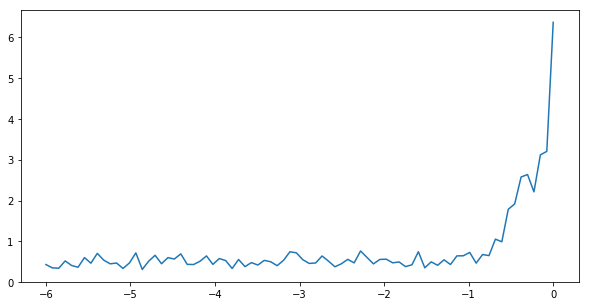

In [85]:
plt.figure(figsize=(10, 5))
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()

In [ ]:
# unfreeze top model layers will not help to increase accuracy
training_loop(model, train_dl, val_dl, steps=2, lr_optimal=1e-4)

In [57]:
p = PATH/"model-cls-s2.pth"
save_model(model, p)

In [64]:
p = PATH/"model-cls-s2.pth"
# model = clsNet().cuda()
model.load_state_dict(torch.load(p))

### Check classification result

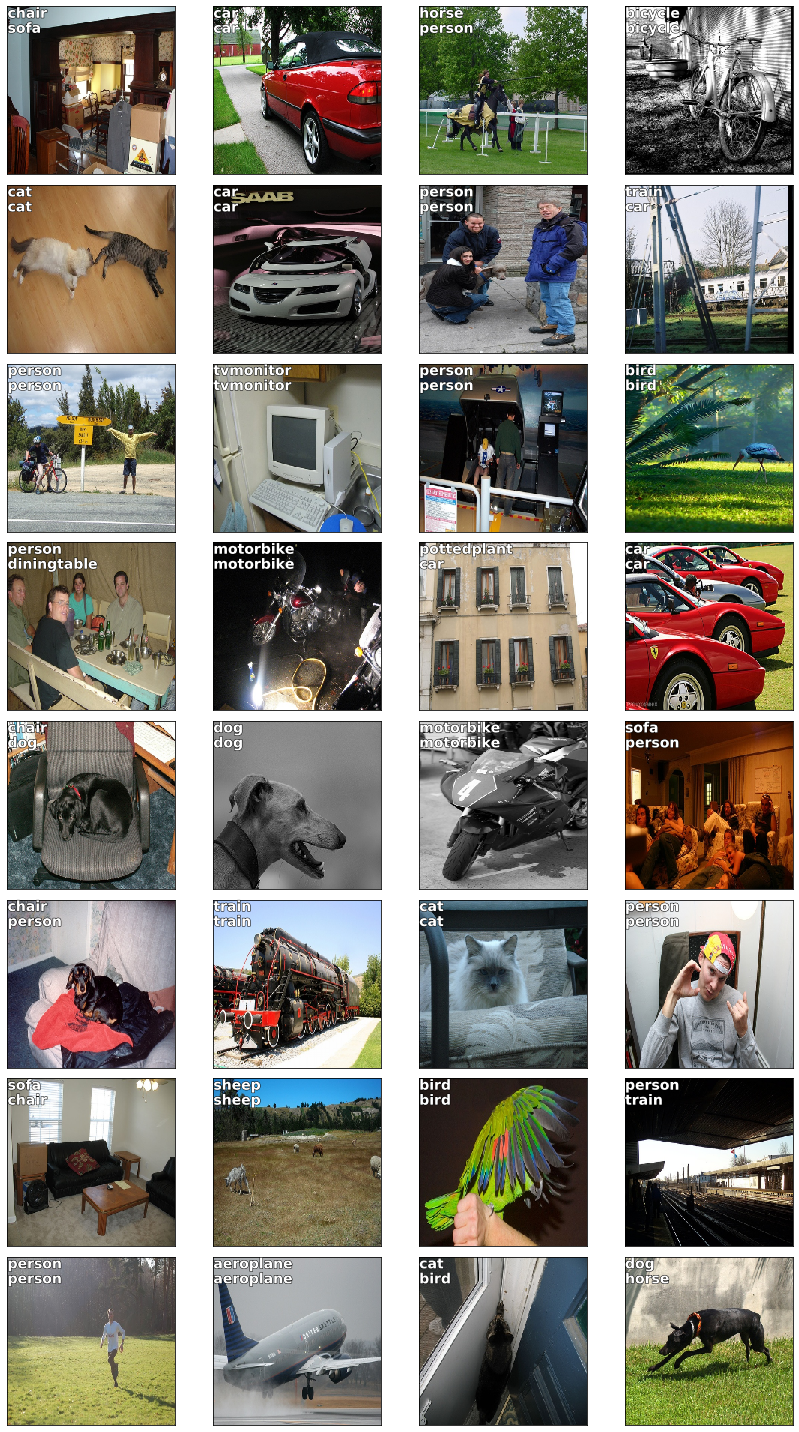

In [87]:
fig, axes = plt.subplots(8, 4, figsize=(12, 20))
X, y = next(iter(val_dl))
# print(X.shape, y.shape)
y_hat = model(X.float().cuda())
_, pred = torch.max(y_hat, 1)
for i, ax in enumerate(axes.flat):
    img = denormalize(X[i].permute(1, 2, 0).numpy())
#     print(img.shape)
    b = y[i]
    label = list(label_encoding.keys())[list(label_encoding.values()).index(b)]
    pred_label = list(label_encoding.keys())[list(label_encoding.values()).index(pred[i])]
    ax = show_img(img, ax=ax)
    draw_text(ax, (0, 0), label)
    draw_text(ax, (0, 20), pred_label)
plt.tight_layout()

## Detect Single Bounding Box

### Load data

Unlike a classification problem, except for the images, the bounding boxes also need to be transformed in exactly the same way as images to remain at the same relative place.

In [43]:
train_bbox_df = pd.read_csv(PATH/'tmp/train_bbox.csv')
val_bbox_df = pd.read_csv(PATH/'tmp/val_bbox.csv')

In [44]:
train_bbox_df.head(5)

fn  label            bbox
0  VOCdevkit/VOC2007/JPEGImages/000012.jpg      6  155 96 196 174
1  VOCdevkit/VOC2007/JPEGImages/000017.jpg     12   89 77 314 259
2  VOCdevkit/VOC2007/JPEGImages/000023.jpg     14     2 1 241 461
3  VOCdevkit/VOC2007/JPEGImages/000026.jpg      6   89 124 248 88
4  VOCdevkit/VOC2007/JPEGImages/000032.jpg      0  103 77 272 106

In [49]:
class singleBboxDataset(Dataset):
    def __init__(self, dataset, transforms=False, sz=img_size):
        self.dataset = dataset
        self.path = self.dataset['fn'].values
        self.sz = img_size
        self.transforms = transforms
        self.y1 = self.dataset['label'].values
        self.y2 = np.array([[float(num) for num in b.split(' ')] for b in dataset['bbox'].values])
        
    def __len__(self):
        return len(self.y1)
    
    def tsfm(self, x, bbox, size):
        random_degree = (np.random.random()-.50)*20
        Y = make_bb_px(bbox, x)
            
        # resize
        x_resize = cv2.resize(x, (self.sz, self.sz))
        y_resize = cv2.resize(Y, (self.sz, self.sz))
        # then rotate
        x_rot = rotate_cv(x_resize, random_degree)
        y_rot = rotate_cv(y_resize, random_degree, bbox=True)
        # then random flip
        if np.random.random() > 0.5: 
            x_rot = np.fliplr(x_rot).copy()
            y_rot = np.fliplr(y_rot).copy()
        
        return x_rot, bb_hw(to_bb(y_rot))
    
    def __getitem__(self, i):
        path = '../'+self.path[i]
        X = load_image(str(path))
        y1 = self.y1[i]
        y2 = self.y2[i]
        if self.transforms:
            X, y2 = self.tsfm(X, y2, self.sz)
        else:
            Y = make_bb_px(y2, X)
            X = cv2.resize(X, (self.sz, self.sz))
            y2 = to_bb(cv2.resize(Y, (self.sz, self.sz)))
        X = normalize(X)
        return X.transpose(2, 0, 1), y1, y2

In [50]:
voc_so_train = singleBboxDataset(train_bbox_df, transforms=True)
voc_so_valid = singleBboxDataset(val_bbox_df)

In [51]:
train_dl = DataLoader(voc_so_train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(voc_so_valid, batch_size=batch_size)

In [52]:
X, y1, y2 = next(iter(train_dl))

In [53]:
X.shape, y1.shape, y2.shape

(torch.Size([64, 3, 300, 300]), torch.Size([64]), torch.Size([64, 4]))

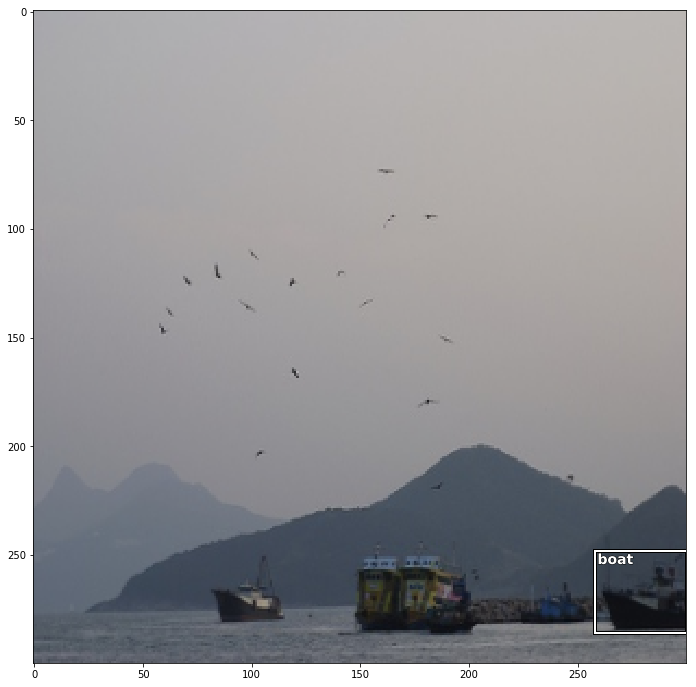

In [54]:
# check augmentation of bounding box
idx = random.randrange(32)
img = denormalize(X[idx].permute(1, 2, 0).numpy())
ax = show_img(img, figsize=(12, 12))
draw_rect(ax, y2[idx])
text = list(label_encoding.keys())[list(label_encoding.values()).index(y1[idx])]
draw_text(ax, y2[idx][:2]+1, text)

### Model

In [55]:
class singleBbNet(nn.Module):
    def __init__(self, n_classes=20):
        super(singleBbNet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        layers = list(resnet.children())[:-2]
        self.top_model = nn.Sequential(*layers).cuda()
        self.out = 512
        self.bn1 = nn.BatchNorm1d(self.out)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(self.out, 512)
        self.fc2 = nn.Linear(512, n_classes)
        self.fc3 = nn.Linear(512, 4)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flatenning
#         x = nn.Dropout(0.5)(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
#         x = nn.Dropout(0.5)(x)
        x = self.bn2(x)
        x_class = self.fc2(x)
        x_bb = self.fc3(x)
        return x_class, x_bb

In [56]:
model_bb_1 = singleBbNet().cuda()

In [63]:
# With 20 classes, the monkey model should have an accuracy around 0.05
val_metrics_bb_1(model_bb_1, val_dl)

Total valid loss 6.207, L1 loss: 2.720, accuracy 0.012


(6.2071082521719765, 0.011553784860557768)

### Learning Rate Finder

In [64]:
def detn_loss(out_class, y_class, out_bb, y_bb):
    out_bb = torch.sigmoid(out_bb)*224
    # cross entropy: around 2-3
    # l1 loss: >90
    return F.l1_loss(out_bb, y_bb)/30 + F.cross_entropy(out_class, y_class)


def detn_l1(out_bb, y_bb):
    out_bb = torch.sigmoid(out_bb)*224
    return F.l1_loss(out_bb, y_bb).item()/30


# def detn_acc(out_class, y_class):
#     from sklearn.metrics import accuracy_score
#     return accuracy_score(y_class.cpu(), out_class.cpu())

In [65]:
def LR_range_finder_bb_1(model, train_dl, lr_low=1e-6, lr_high=1, epochs=4):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    lrs = lr_range(slice(lr_low, lr_high), iterations)
    model.train()
    ind = 0
    correct = 0
    for i in range(epochs):
        for x, y_class, y_bb in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
#             loss = F.cross_entropy(out_class, y_class)
#             loss += F.l1_loss(out_bb, y_bb)
            loss = detn_loss(out_class, y_class, out_bb, y_bb)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
    load_model(model, str(p))
    torch.cuda.empty_cache()
    return lrs, losses

In [66]:
model_bb_1 = singleBbNet().cuda()

In [67]:
lrs, losses = LR_range_finder_bb_1(model_bb_1, train_dl, lr_low=1e-6, lr_high=1, epochs=2)

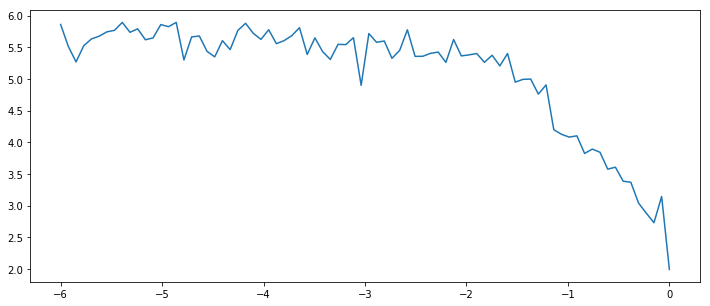

In [68]:
plt.figure(figsize=(12, 5))
plt.plot([np.log10(l) for l in lrs], losses)
plt.show()

### Training

In [69]:
def one_cycle_bb_1(model, train_dl, valid_dl, lr_optimal=1e-4, div_factor=25, epochs=4):
    idx = 0
    iterations = epochs * len(train_dl)
    lrs = get_triangular_lr(lr_optimal, div_factor, iterations)
    moms = get_triangular_mom(0.85, 0.95, iterations)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y_class, y_bb) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[idx], mom=moms[idx])
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
#             loss = F.cross_entropy(out_class, y_class)
#             loss += F.l1_loss(torch.sigmoid(out_bb)*224, y_bb)
            loss = detn_loss(out_class, y_class, out_bb, y_bb)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
            torch.cuda.empty_cache()
        train_losses.append(sum_loss/total)
        print(f"Total train loss: {(sum_loss/total):.3f}")
        val_loss, val_acc = val_metrics_bb_1(model, valid_dl)
        val_losses.append(val_loss)
    return train_losses, val_losses

In [70]:
def val_metrics_bb_1(model, valid_dl):
    model.eval()
    total = 0
    sum_ce_loss = 0
    sum_l1_loss = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y_class, y_bb) in enumerate(valid_dl):
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda().long()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss = detn_loss(out_class, y_class, out_bb, y_bb)
        l1_loss = detn_l1(out_bb, y_bb)
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += batch*(loss.item())
        total += batch
        torch.cuda.empty_cache()
    accuracy = correct/total
    print(f"Total valid loss {(sum_loss/total):.3f}, L1 loss: {l1_loss:.3f}, accuracy {accuracy:.3f}")
    return sum_loss/total, accuracy

In [71]:
def training_loop_bb_1(model, train_dl, valid_dl, steps=3, lr_optimal=1e-3, div_factor=25, epochs=4):
    for i in range(steps):
        start = datetime.now() 
        train_loss, val_loss = one_cycle_bb_1(model, train_dl, valid_dl, lr_optimal, div_factor, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [72]:
model_bb_1 = singleBbNet().cuda()

In [73]:
training_loop_bb_1(model_bb_1, train_dl, val_dl, steps=4, lr_optimal=8e-2, div_factor=25, epochs=5)

Total train loss: 4.931
Total valid loss 4.562, L1 loss: 2.798, accuracy 0.620
Total train loss: 3.326
Total valid loss 4.142, L1 loss: 2.920, accuracy 0.696
Total train loss: 2.611
Total valid loss 4.423, L1 loss: 2.807, accuracy 0.512
Total train loss: 2.313
Total valid loss 3.597, L1 loss: 2.649, accuracy 0.786
Total train loss: 2.180
Total valid loss 3.514, L1 loss: 2.683, accuracy 0.802
----End of step Time elapsed 0:05:53.499860
Total train loss: 2.175
Total valid loss 3.618, L1 loss: 2.584, accuracy 0.790
Total train loss: 2.108
Total valid loss 3.568, L1 loss: 2.323, accuracy 0.735
Total train loss: 2.005
Total valid loss 3.207, L1 loss: 2.381, accuracy 0.778
Total train loss: 1.882
Total valid loss 3.539, L1 loss: 2.698, accuracy 0.792
Total train loss: 1.802
Total valid loss 3.347, L1 loss: 2.354, accuracy 0.804
----End of step Time elapsed 0:05:49.559940
Total train loss: 1.800
Total valid loss 3.902, L1 loss: 2.527, accuracy 0.727
Total train loss: 1.798
Total valid loss 3.

In [74]:
p = PATH/"model-bb1-s1.pth"
save_model(model_bb_1, p)

#### Check result without unfreezing top model layers

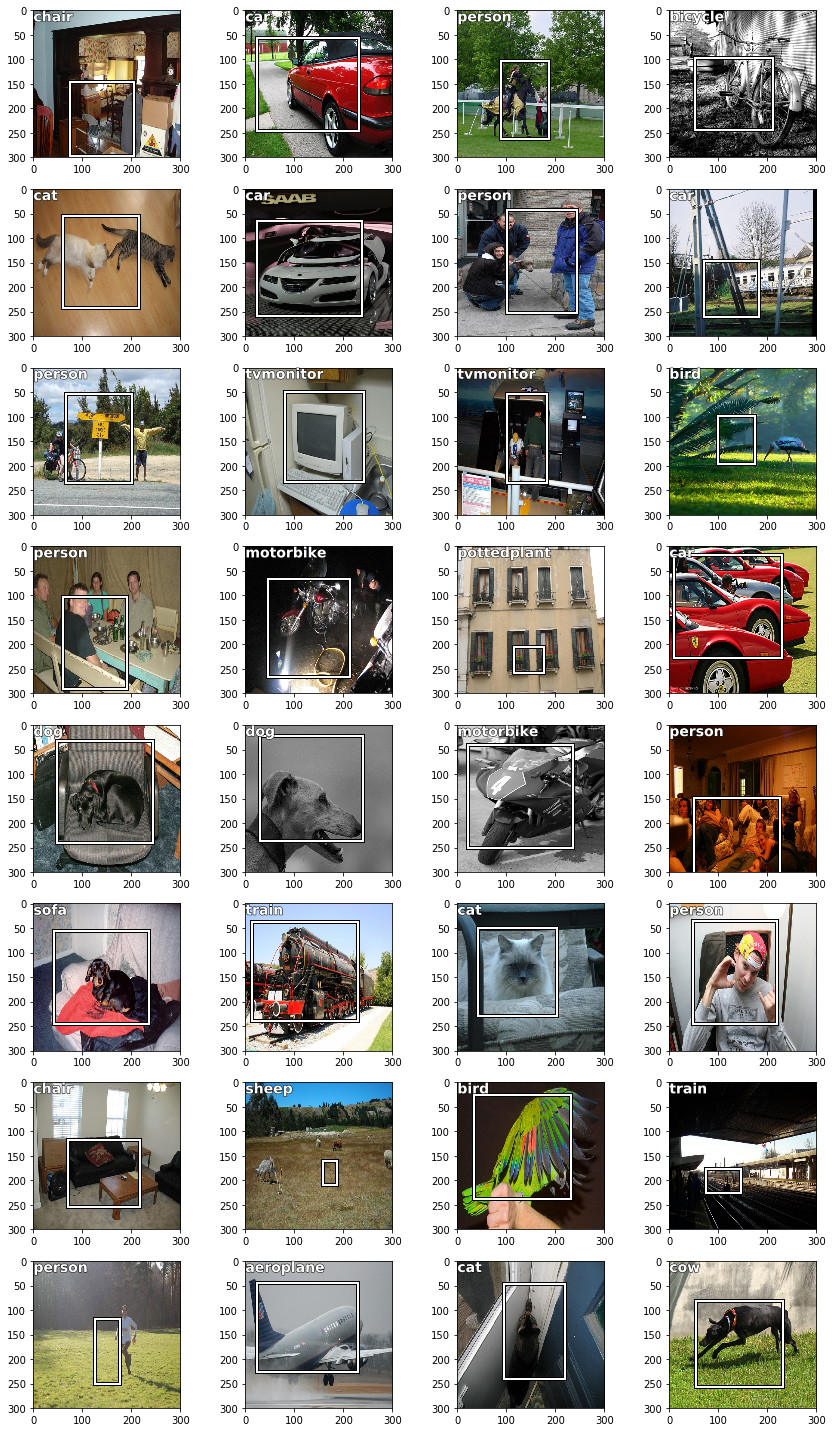

In [75]:
fig, axes = plt.subplots(8, 4, figsize=(12, 20))
X, y_class, y_bb = next(iter(val_dl))
# print(X.shape, y.shape)
out_class, out_bb = model_bb_1(X.float().cuda())
_, pred = torch.max(out_class, 1)
for i, ax in enumerate(axes.flat):
    img = denormalize(X[i].permute(1, 2, 0).numpy())
    b = (torch.sigmoid(out_bb[i].detach().cpu())*224).numpy()
    label = list(label_encoding.keys())[list(label_encoding.values()).index(pred[i])]
    ax = show_img(img, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, (0, 0), label)
plt.tight_layout()

#### Unfreezing top model

Why the metrics vary so much?

In [65]:
p = PATH/"model-bb1-s1.pth"
model_bb_1 = singleBbNet().cuda()
model_bb_1.load_state_dict(torch.load(p))

In [76]:
unfreeze(model_bb_1, 7)
unfreeze(model_bb_1, 6)

In [77]:
torch.cuda.empty_cache()

In [78]:
training_loop_bb_1(model_bb_1, train_dl, val_dl, steps=2, lr_optimal=4e-2, div_factor=25, epochs=5)

Total train loss: 1.515
Total valid loss 4.101, L1 loss: 1.992, accuracy 0.570
Total train loss: 1.487
Total valid loss 5.212, L1 loss: 2.716, accuracy 0.618
Total train loss: 1.369
Total valid loss 3.505, L1 loss: 2.184, accuracy 0.800
Total train loss: 1.229
Total valid loss 4.453, L1 loss: 2.300, accuracy 0.799
Total train loss: 1.160
Total valid loss 4.748, L1 loss: 2.230, accuracy 0.810
----End of step Time elapsed 0:06:34.638471
Total train loss: 1.143
Total valid loss 4.907, L1 loss: 2.423, accuracy 0.792
Total train loss: 1.137
Total valid loss 6.896, L1 loss: 2.272, accuracy 0.518
Total train loss: 1.168
Total valid loss 4.567, L1 loss: 2.194, accuracy 0.705
Total train loss: 1.085
Total valid loss 5.957, L1 loss: 2.275, accuracy 0.793
Total train loss: 1.034
Total valid loss 5.727, L1 loss: 2.160, accuracy 0.808
----End of step Time elapsed 0:06:34.041628


In [79]:
p = PATH/"model-bb1-s2.pth"
save_model(model_bb_1, p)

In [82]:
p = PATH/"model-bb1-s2.pth"
# model_bb_1 = singleBbNet().cuda()
model_bb_1.load_state_dict(torch.load(p))

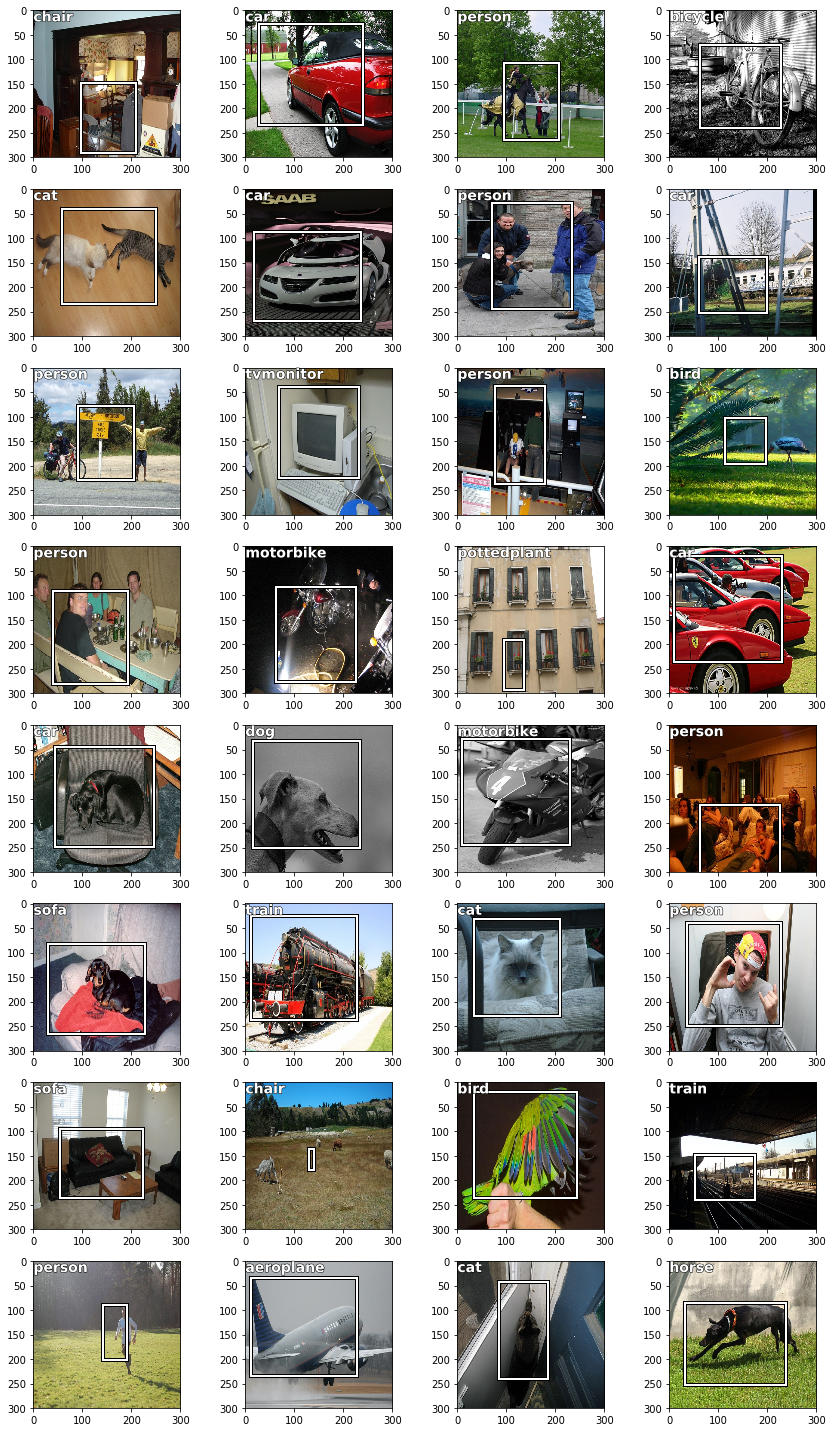

In [80]:
fig, axes = plt.subplots(8, 4, figsize=(12, 20))
X, y_class, y_bb = next(iter(val_dl))
# print(X.shape, y.shape)
out_class, out_bb = model_bb_1(X.float().cuda())
_, pred = torch.max(out_class, 1)
for i, ax in enumerate(axes.flat):
    img = denormalize(X[i].permute(1, 2, 0).numpy())
    b = (torch.sigmoid(out_bb[i].detach().cpu())*224).numpy()
    label = list(label_encoding.keys())[list(label_encoding.values()).index(pred[i])]
    ax = show_img(img, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, (0, 0), label)
plt.tight_layout()